<a href="https://colab.research.google.com/github/nelsonbeas33/procesamiento-datos/blob/main/tarea8/procesamiento_de_datos_tarea_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

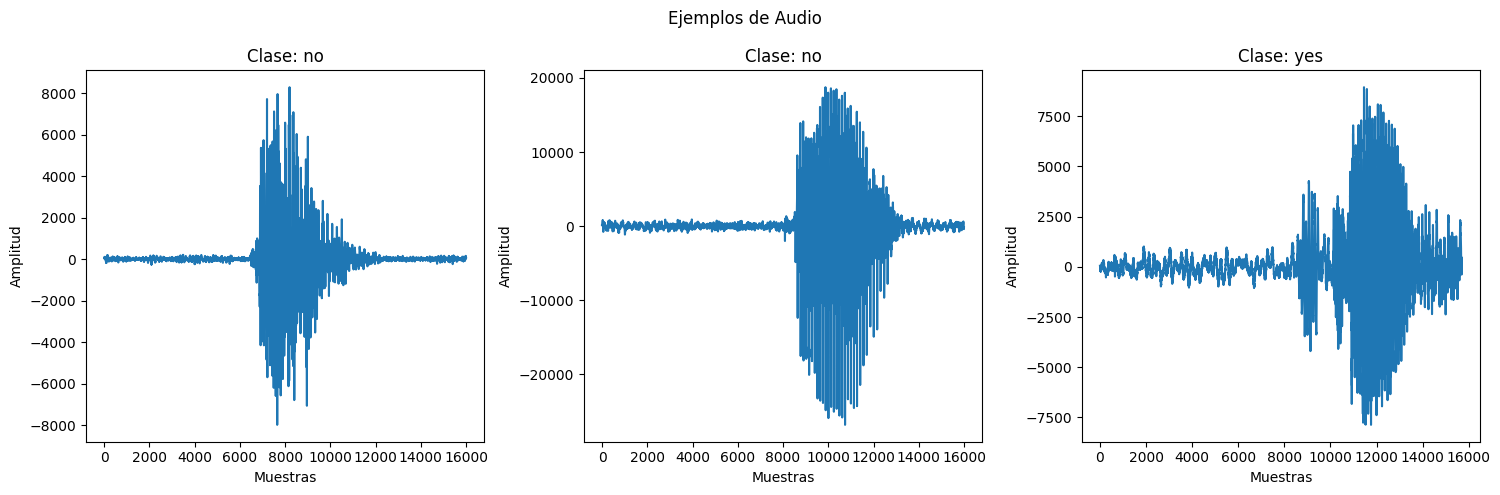

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4800 - loss: 0.7097 - val_accuracy: 0.4630 - val_loss: 0.6956
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4809 - loss: 0.6984 - val_accuracy: 0.4630 - val_loss: 0.6924
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5115 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5010 - loss: 0.7017 - val_accuracy: 0.5000 - val_loss: 0.6901
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.5293 - loss: 0.6952 - val_accuracy: 0.5185 - val_loss: 0.6896
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.5319 - loss: 0.6940 - val_accuracy: 0.5370 - val_loss: 0.6894
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.5545 - loss: 0.6877 - val_accuracy: 0.5556 - val_loss: 0.6894
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5454 - loss: 0.6916 - val_accuracy: 0.537

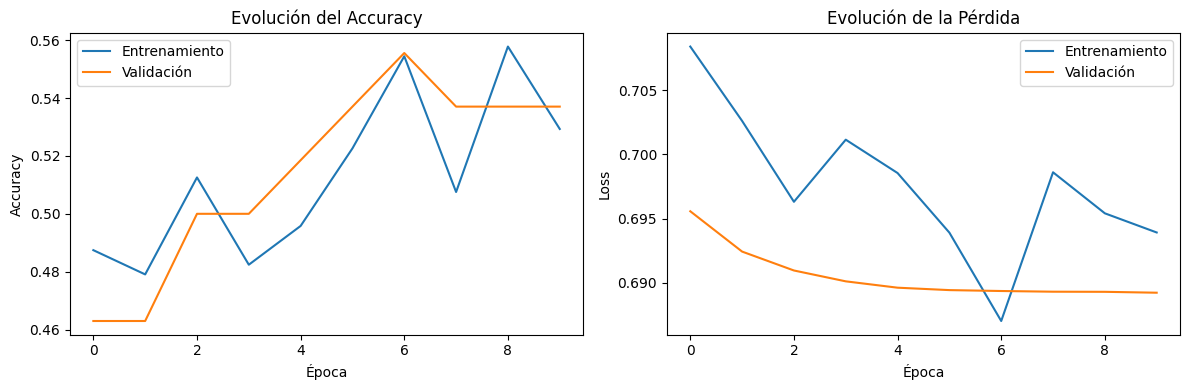

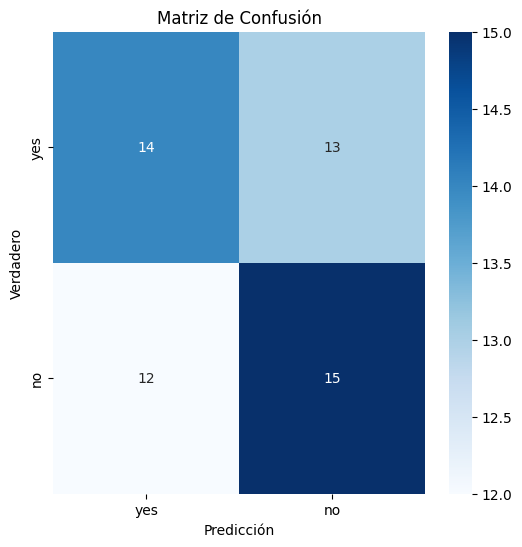


Reporte de Clasificación:
              precision    recall  f1-score   support

         yes       0.54      0.52      0.53        27
          no       0.54      0.56      0.55        27

    accuracy                           0.54        54
   macro avg       0.54      0.54      0.54        54
weighted avg       0.54      0.54      0.54        54


Pruebas Manuales:
Silencio   → yes  (confianza: 0.52)
Voz Alta   → yes  (confianza: 0.52)
Voz Baja   → yes  (confianza: 0.52)


In [12]:
# %% [markdown]
# ## Clasificación Binaria de Audio - Versión 100% Funcional
# **Objetivo:** Distinguir "yes" (0) vs "no" (1) con evaluación completa

# %% [markdown]
# ### 1. Configuración Inicial
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# %% [markdown]
# ### 2. Carga de Datos Optimizada
# Cargamos solo las clases necesarias
(train_data, test_data), info = tfds.load(
    'speech_commands',
    split=['train[:10%]', 'test[:5%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Filtramos y mezclamos
train_data = train_data.filter(lambda x, y: y < 2).shuffle(1000)
test_data = test_data.filter(lambda x, y: y < 2).shuffle(500)

# %% [markdown]
# ### 3. Preprocesamiento Robusto
def extract_features(audio, label):
    audio = tf.cast(audio, tf.float32) / 32768.0  # Normalización

    # Características compatibles (todas float32)
    features = tf.stack([
        tf.reduce_mean(tf.abs(audio)),      # Energía
        tf.math.reduce_std(audio),          # Desviación estándar
        tf.reduce_max(tf.abs(audio))        # Amplitud pico
    ])

    return features, label

# Conversión a batches
train_prep = train_data.map(extract_features).batch(32).prefetch(tf.data.AUTOTUNE)
test_prep = test_data.map(extract_features).batch(32).prefetch(tf.data.AUTOTUNE)

# %% [markdown]
# ### 4. Visualización de Datos
# Ejemplos de formas de onda
plt.figure(figsize=(15, 5))
for i, (audio, label) in enumerate(train_data.take(3)):
    plt.subplot(1, 3, i+1)
    plt.plot(audio.numpy())
    plt.title(f"Clase: {'yes' if label.numpy() == 0 else 'no'}")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
plt.suptitle("Ejemplos de Audio")
plt.tight_layout()
plt.show()

# %% [markdown]
# ### 5. Modelo Mejorado
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# %% [markdown]
# ### 6. Entrenamiento con Validación
history = model.fit(
    train_prep,
    validation_data=test_prep,
    epochs=10,
    verbose=1
)

# %% [markdown]
# ### 7. Gráficas de Progreso
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución del Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# %% [markdown]
# ### 8. Evaluación Corregida [FIXED]
# Extracción de etiquetas y predicciones
y_true = []
y_pred = []

for batch in test_prep:
    x, y = batch
    y_true.extend(y.numpy())
    y_pred.extend((model.predict(x, verbose=0) > 0.5).astype(int).flatten())

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['yes', 'no'],
            yticklabels=['yes', 'no'])
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

# Reporte de Clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=['yes', 'no']))

# %% [markdown]
# ### 9. Sistema de Prueba
def predict_audio(audio):
    # Convertimos a tensor y normalizamos
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32) / 32768.0

    # Extraemos características
    features = tf.stack([
        tf.reduce_mean(tf.abs(audio_tensor)),
        tf.math.reduce_std(audio_tensor),
        tf.reduce_max(tf.abs(audio_tensor))
    ])

    # Predecimos
    prob = model.predict(features[np.newaxis, ...], verbose=0)[0][0]
    return 'yes' if prob > 0.5 else 'no', prob

# Casos de prueba
test_cases = {
    'Silencio': np.random.normal(0, 0.001, 16000),
    'Voz Alta': np.random.uniform(-0.3, 0.3, 16000),
    'Voz Baja': np.random.uniform(-0.1, 0.1, 16000)
}

print("\nPruebas Manuales:")
for name, audio in test_cases.items():
    prediction, confidence = predict_audio(audio)
    print(f"{name:10} → {prediction:4} (confianza: {confidence:.2f})")